In [1]:
import numpy as np
from scipy.stats import bernoulli
from scipy.linalg import hadamard
%matplotlib inline
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")
plt.style.use('bmh')

In [2]:
N = 16 # no. of clients.
D = 512 # length of array each client send.
ITERS = 4096 # no. of iterations.
X = np.random.randn(N, D) # generating normal distribution for Clients.
Ks = 2**np.arange(1, 7) # various levels of k

# DME Schemes

In [3]:
def Bi(arr, k):
    """A function to generate quantization levels.

    Args:
        arr (ndarray): parameters to quantize. shape=(d,).
        k (int): no. of quantization levels.

    Returns:
        ndarray: an array of quantization levels
    """

    # the below code is straight forward from the paper
    # the whole function can be replaced with
    # np.linspace(low=np.min(xi), high=np.max(xi), num=k)
    
    si = np.max(arr) - np.min(arr)
    levels = np.arange(k)*(si/(k-1))
    return np.min(arr) + levels

def encoding(arr, k, iters, d):
    """Encoding function.

    Args:
        xi (ndarray): parameters to quantize. shape=(d,).
        brs (ndarray): an array of quantization levels. shape=(k,).
        iters (int): no. of iterations.
        d (int): dimensions of the array.

    Returns:
        ndarray: an array of 1s and 0s with shape(iters, d)
        ndarray: an array of left and right quantizing points of each xi.
                 shape=(d, 2)
    """
    bi = Bi(arr, k) # generating array of quantization levels.

    # np.searchsorted finds the B(r)s of each xi.
    # i.e, left point of quantizing interval in which each xi belong to.
    br_ids = np.searchsorted(bi, arr, side='right')-1

    # stacking them to make them look like points.
    # (left point, right point)
    brs = np.vstack((br_ids, br_ids+1)).T

    # as the np.searchsorted outputs the last index of bi for np.max(xi),
    # ids+1 will be out of index.
    # outputing last index of bi as both left and right index will solve the problem.
    brs[brs==k] = k-1

    # replacing indices with quantization values.
    brs = bi[brs]

    # finds probabilities of the elements,
    # outputs 0 for np.max(xi).
    probs = np.where(
        (brs[:, 1] - brs[:, 0]) != 0,
        (arr - brs[:, 0])/(brs[:, 1]-brs[:, 0]),0)
    
    # outputs 1s and 0s based on the probabilities,
    # repeats the above line for iters no. of times.
    return bernoulli.rvs(probs, size=(iters, d)), brs


def decoding(brs, encs):
    """Decoding function.

    Args:
        brs (ndarray): an array of quantization levels.
                        shape = (k,)
        encs (ndarray): an arrays of 0s and 1s (output of encoding function).
                        shape = (iters, d)

    Returns:
        ndarray: a decoded array. shape=(iters, d)
    """
    
    # for each iteration:
        #  replaces 1s with their corresponding B(r+1)s
        #  and 0s with corresponding B(r)s.
    # np.max(xi) prob is 0. so, this function output with last level...
    # value of Bi as the decoded value.
    return (np.where(encs, brs[:, 1], brs[:, 0]))

## Stochastic K level Quantization

In [4]:
def sto_k(k, n=N, d=D, ITERS=ITERS, X=X):
    """Stochastic K-level Quantization

    Args:
        k (int): no. of Quantization levels.
        n (int, optional): no. of clients. Defaults to N.
        d (int, optional): length of array for each user. Defaults to D.
        ITERS (int, optional): no. of iterations. Defaults to ITERS.
        X (ndarray, optional): array of clients with their d-dimensional array. Defaults to X.

    Returns:
        int: Mean Squared Error.
    """
    
    total = 0
    for xi in X: # for each client:
        # xi.shape = (d,)

        encs, brs = encoding(arr=xi, k=k, iters=ITERS, d=d)
        yi = decoding(brs=brs, encs=encs.copy())

        # adding the encoded and decoded xi of each xi (in order to take their mean).
        total += yi

    # dividing by number of client (inorder to take their mean).
    x_hat_mean = total / n # shape = (iters, d)

    # calculating mean along dimensions of several users
    x_mean = np.mean(X, axis=0)

    # expected error: (using sec-1.2 in DME)
    # calculating norm for each iteration. output_shape=(iters,)
    # and then calculating mean of the iterations. output_type: scalar.
    err = np.mean(np.linalg.norm((x_hat_mean - x_mean), axis=1)**2)
    return err
    

## Stochastic Rotation Quantization

In [5]:
def sto_rot(k, n=N, d=D, ITERS=ITERS, X=X):
    """Stochastic Rotation Quantization (k level)

    Args:
        k (int): no. of quantization levels
        n (int, optional): no. of Clients. Defaults to N.
        d (int, optional): no. of dimensions of parameter array of each client. Defaults to D.
        ITERS (int, optional): no. of iterations. Defaults to ITERS.
        X (ndarray, optional): array of clients with their d-dimensional array. Defaults to X.

    Returns:
        int: Mean Squared Error.
    """    
    # X = np.random.rand(n, ITERS, d)
    
    # generating Rotation Matrix.
    R = hadamard(d) @ np.diag(
        np.random.choice([1, -1], size=d, p=[0.5, 0.5])
    ) / np.sqrt(d)
    
    # checking orthogonality property of Rotation matrix.
    assert np.allclose(np.eye(d), R @ R.T), "R is not orthogonal."
    
    total = 0.0
    
    for xi in X: # for each client
        # Preprocessing:
        zi = R @ xi
        # checking if ||zi||==||xi||
        assert np.allclose(
            np.linalg.norm(zi),
            np.linalg.norm(xi)
        ), "l2 norm zi != l2 norm xi"
        
        encs, brs = encoding(arr=zi, k=k, iters=ITERS, d=d)
        yi = decoding(brs=brs, encs=encs.copy())

        # adding the encoded and decoded xi of each xi (in order to take their mean).
        total += yi
    # dividing by number of client (inorder to take their mean).
    Z_hat_mean = total/n 
    
    # doing inv(R)@zi for each iteration.
    x_hat_mean = np.transpose(np.linalg.inv(R) @ Z_hat_mean.T)

    # calculating mean along dimensions of several users
    x_mean = np.mean(X, axis=0)

    # expected error: (using sec-1.2 in DME)
    # calculating norm for each iteration. output_shape=(iters,)
    # and then calculating mean of the iterations. output_type: scalar.
    error_obs = np.mean((np.linalg.norm((x_mean - x_hat_mean), axis=1)**2))
    return error_obs

## Plots of DME

In [6]:
er_k = []
er_rot = []

for k in Ks:
    er_k.append(sto_k(k=k))
    er_rot.append(sto_rot(k=k))

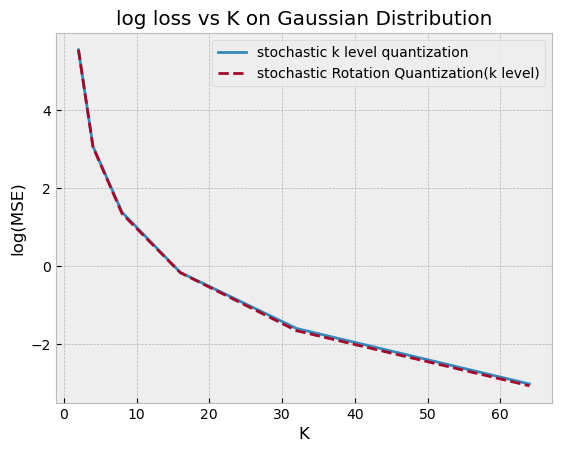

In [7]:
plt.plot(Ks, np.log(er_k), label='stochastic k level quantization')
plt.plot(Ks, np.log(er_rot), '--',label='stochastic Rotation Quantization(k level)')
plt.xlabel("K")
plt.ylabel("log(MSE)")
plt.title("log loss vs K on Gaussian Distribution")
plt.legend()
plt.show()

# New Methods (Biased and keep half of the diagonal to 1)

In [8]:
def decoding_biased(brs, encs):
    """new Decoding function (biased)

    Args:
        brs (ndarray): Quantization levels
        encs (ndarray): output of encoding funtion

    Returns:
        ndarray: a decoded array.
    """

    a = (3*brs[:, 1] + brs[:, 0])/4 # instead of brs[:, 1] (i.e, B(r=+1))
    b = (3*brs[:, 0]+brs[:, 1])/4 # instead of brs[:, 0] (i.e, B(r))
    # for each iteration:
        #  replaces 1s with their corresponding a
        #  and 0s with corresponding b.
    return np.where(encs, a, b)

## Stochastic K level Quantization new (Biased)

In [9]:
def sto_k_biased(k, n=N, d=D, ITERS=ITERS, X=X):
    """Stochastic K-level Quantization new(biased)

    Args:
        k (int): no. of Quantization levels.
        n (int, optional): no. of clients. Defaults to N.
        d (int, optional): length of array for each user. Defaults to D.
        ITERS (int, optional): no. of iterations. Defaults to ITERS.
        X (ndarray, optional): array of clients with their d-dimensional array. Defaults to X.

    Returns:
        int: Mean Squared Error.
    """
    
    total = 0
    for xi in X: # for each client:
        # xi.shape = (d,)

        encs, brs = encoding(arr=xi, k=k, iters=ITERS, d=d)
        yi = decoding_biased(brs=brs, encs=encs.copy())

        # adding the encoded and decoded xi of each xi (in order to take their mean).
        total += yi

    # dividing by number of client (inorder to take their mean).
    x_hat_mean = total / n # shape = (iters, d)

    # calculating mean along dimensions of several users
    x_mean = np.mean(X, axis=0)

    # expected error: (using sec-1.2 in DME)
    # calculating norm for each iteration. output_shape=(iters,)
    # and then calculating mean of the iterations. output_type: scalar.
    err = np.mean(np.linalg.norm((x_hat_mean - x_mean), axis=1)**2)
    return err
    

## Stochastic Rotation Quantization new (Biased)

In [10]:
def sto_rot_biased(k, n=N, d=D, ITERS=ITERS, X=X):
    """Stochastic Rotation Quantization (k level) new(biased)

    Args:
        k (int): no. of quantization levels
        n (int, optional): no. of Clients. Defaults to N.
        d (int, optional): no. of dimensions of parameter array of each client. Defaults to D.
        ITERS (int, optional): no. of iterations. Defaults to ITERS.
        X (ndarray, optional): array of clients with their d-dimensional array. Defaults to X.

    Returns:
        int: Mean Squared Error.
    """
    
    # generating Rotation Matrix.
    R = hadamard(d) @ np.diag(
        np.random.choice([1, -1], size=d, p=[0.5, 0.5])
    ) / np.sqrt(d)
    
    # checking orthogonality property of Rotation matrix.
    assert np.allclose(np.eye(d), R @ R.T), "R is not orthogonal."
    
    total = 0.0
    
    for xi in X: # for each client
        # Preprocessing:
        zi = R @ xi
        # checking if ||zi||==||xi||
        assert np.allclose(
            np.linalg.norm(zi),
            np.linalg.norm(xi)
        ), "l2 norm zi != l2 norm xi"
        
        encs, brs = encoding(arr=zi, k=k, iters=ITERS, d=d)
        yi = decoding_biased(brs=brs, encs=encs.copy())

        # adding the encoded and decoded xi of each xi (in order to take their mean).
        total += yi
    # dividing by number of client (inorder to take their mean).
    Z_hat_mean = total/n 
    
    # doing inv(R)@zi for each iteration.
    x_hat_mean = np.transpose(np.linalg.inv(R) @ Z_hat_mean.T)

    # calculating mean along dimensions of several users
    x_mean = np.mean(X, axis=0)

    # expected error: (using sec-1.2 in DME)
    # calculating norm for each iteration. output_shape=(iters,)
    # and then calculating mean of the iterations. output_type: scalar.
    error_obs = np.mean((np.linalg.norm((x_mean - x_hat_mean), axis=1)**2))
    return error_obs

## Stochastic Rotation Quantization (that half diagonal thing)

In [11]:
def sto_rot_hfdiag(k, n=N, d=D, ITERS=ITERS, X=X):
    """Stochastic Rotation Quantization (k level) by keeping half of 
       the diagonal elements fixed to 1.

    Args:
        k (int): no. of quantization levels
        n (int, optional): no. of Clients. Defaults to N.
        d (int, optional): no. of dimensions of parameter array of each client. Defaults to D.
        ITERS (int, optional): no. of iterations. Defaults to ITERS.
        X (ndarray, optional): array of clients with their d-dimensional array. Defaults to X.

    Returns:
        int: Mean Squared Error.
    """
    
    # generating rotation matrix with half of the diagonal elements fixed to 1.
    # and remaining half are 1, -1 generated with 0.5 probability each.
    R = hadamard(d) @ np.diag(
        np.hstack(
        (np.ones(d//2), 
         np.random.choice([1, -1], size=d//2, p=[0.5, 0.5])))
    ) / np.sqrt(d)
    
    # checking orthogonality property of Rotation matrix.
    assert np.allclose(np.eye(d), R @ R.T), "R is not orthogonal."
    
    total = 0.0
    
    for xi in X: # for each client
        # Preprocessing:
        zi = R @ xi
        # checking if ||zi||==||xi||
        assert np.allclose(
            np.linalg.norm(zi),
            np.linalg.norm(xi)
        ), "l2 norm zi != l2 norm xi"
        
        encs, brs = encoding(arr=zi, k=k, iters=ITERS, d=d)
        yi = decoding(brs=brs, encs=encs.copy())

        # adding the encoded and decoded xi of each xi (in order to take their mean).
        total += yi
    # dividing by number of client (inorder to take their mean).
    Z_hat_mean = total/n 
    
    # doing inv(R)@zi for each iteration.
    x_hat_mean = np.transpose(np.linalg.inv(R) @ Z_hat_mean.T)

    # calculating mean along dimensions of several users
    x_mean = np.mean(X, axis=0)

    # expected error: (using sec-1.2 in DME)
    # calculating norm for each iteration. output_shape=(iters,)
    # and then calculating mean of the iterations. output_type: scalar.
    error_obs = np.mean((np.linalg.norm((x_mean - x_hat_mean), axis=1)**2))
    return error_obs

## Stochastic Rotation Quantization (using both half diagonal and biased decoder)

In [12]:
def sto_rot_hfdiag_biased(k, n=N, d=D, ITERS=ITERS, X=X):
    """Stochastic Rotation Quantization (k level) by keep half of 
       the diagonal elements fixed to 1. And also we are used biased decoder here.

    Args:
        k (int): no. of quantization levels
        n (int, optional): no. of Clients. Defaults to N.
        d (int, optional): no. of dimensions of parameter array of each client. Defaults to D.
        ITERS (int, optional): no. of iterations. Defaults to ITERS.
        X (ndarray, optional): array of clients with their d-dimensional array. Defaults to X.

    Returns:
        int: Mean Squared Error.
    """
    
    # generating rotation matrix with half of the diagonal elements fixed to 1.
    # and remaining half are 1, -1 generated with 0.5 probability each.
    R = hadamard(d) @ np.diag(
        np.hstack(
        (np.ones(int(d/2)), 
         np.random.choice([1, -1], size=int(d/2), p=[0.5, 0.5])))
    ) / np.sqrt(d)
    
    # checking orthogonality property of Rotation matrix.
    assert np.allclose(np.eye(d), R @ R.T), "R is not orthogonal."
    
    total = 0.0
    
    for xi in X: # for each client
        # Preprocessing:
        zi = R @ xi
        # checking if ||zi||==||xi||
        assert np.allclose(
            np.linalg.norm(zi),
            np.linalg.norm(xi)
        ), "l2 norm zi != l2 norm xi"
        
        encs, brs = encoding(arr=zi, k=k, iters=ITERS, d=d)
        yi = decoding_biased(brs=brs, encs=encs.copy())

        # adding the encoded and decoded xi of each xi (in order to take their mean).
        total += yi
    # dividing by number of client (inorder to take their mean).
    Z_hat_mean = total/n 
    
    # doing inv(R)@zi for each iteration.
    x_hat_mean = np.transpose(np.linalg.inv(R) @ Z_hat_mean.T)

    # calculating mean along dimensions of several users
    x_mean = np.mean(X, axis=0)

    # expected error: (using sec-1.2 in DME)
    # calculating norm for each iteration. output_shape=(iters,)
    # and then calculating mean of the iterations. output_type: scalar.
    error_obs = np.mean((np.linalg.norm((x_mean - x_hat_mean), axis=1)**2))
    return error_obs

## plots (on new methods)

In [13]:
er_k_biased = []
er_rot_biased = []

er_hfdiag = []
er_hfdiag_biased = []

for k in Ks:
    er_k_biased.append(sto_k_biased(k=k))
    er_rot_biased.append(sto_rot_biased(k=k))
    er_hfdiag.append(sto_rot_hfdiag(k=k))
    er_hfdiag_biased.append(sto_rot_hfdiag_biased(k=k))

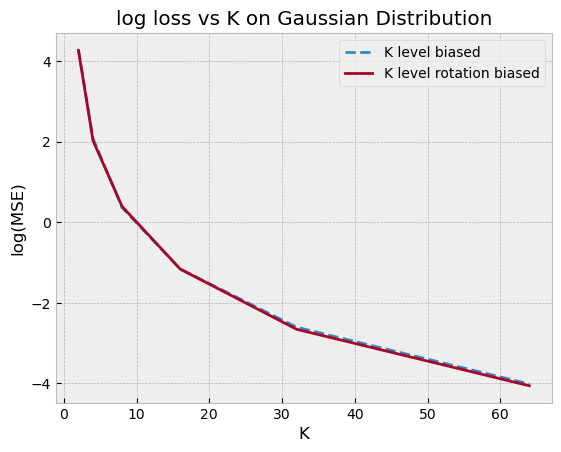

In [19]:
plt.plot(Ks, np.log(er_k_biased), '--', label='K level biased')
plt.plot(Ks, np.log(er_rot_biased), label='K level rotation biased')
plt.title("log loss vs K on Gaussian Distribution")
plt.xlabel('K')
plt.ylabel('log(MSE)')
plt.legend()
plt.show()

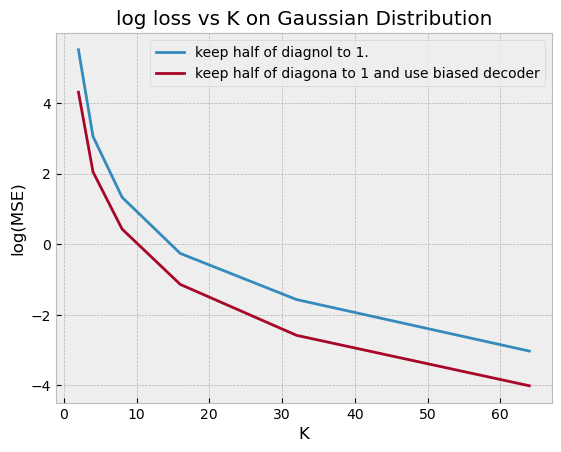

In [20]:
plt.plot(Ks, np.log(er_hfdiag), label='keep half of diagnol to 1.')
plt.plot(Ks, np.log(er_hfdiag_biased), label='keep half of diagona to 1 and use biased decoder')
plt.title("log loss vs K on Gaussian Distribution")
plt.xlabel('K')
plt.ylabel('log(MSE)')
plt.legend()
plt.show()

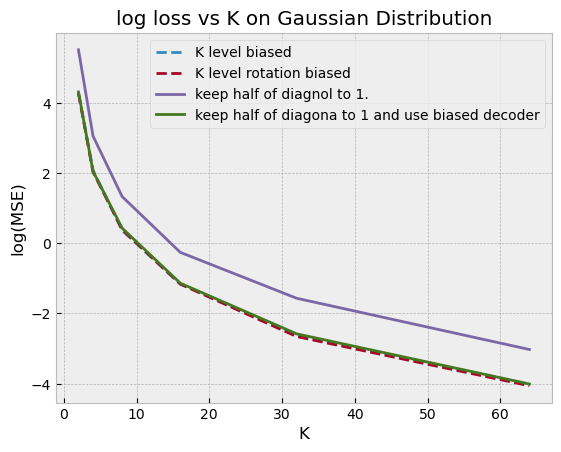

In [22]:
plt.plot(Ks, np.log(er_k_biased), '--', label='K level biased')
plt.plot(Ks, np.log(er_rot_biased),"--" ,label='K level rotation biased')
plt.plot(Ks, np.log(er_hfdiag), label='keep half of diagnol to 1.')
plt.plot(Ks, np.log(er_hfdiag_biased), label='keep half of diagona to 1 and use biased decoder')
plt.title("log loss vs K on Gaussian Distribution")
plt.xlabel('K')
plt.ylabel('log(MSE)')
plt.legend()
plt.show()